# [XGBoost in Python from Start to Finish](https://youtu.be/GrJP9FLV3FE?si=7L1nTkPEoh8kPL8C) Follow through

In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation

In [2]:
df = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# customerID all difference, not help with classifications
df.drop(['customerID'], axis=1, inplace=True)

In [4]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
for col in df.columns:
    #print(df[col].isnull().sum())
    #print(df[col].apply(lambda col: (col == '')).sum())
    #print(df[col].unique())
    print(f"{col}: null: {df[col].isnull().sum()} empty: {df[col].apply(lambda col: (col == '' or col == None or col == ' ')).sum()} vals: {df[col].unique()}")



gender: null: 0 empty: 0 vals: ['Female' 'Male']
SeniorCitizen: null: 0 empty: 0 vals: [0 1]
Partner: null: 0 empty: 0 vals: ['Yes' 'No']
Dependents: null: 0 empty: 0 vals: ['No' 'Yes']
tenure: null: 0 empty: 0 vals: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: null: 0 empty: 0 vals: ['No' 'Yes']
MultipleLines: null: 0 empty: 0 vals: ['No phone service' 'No' 'Yes']
InternetService: null: 0 empty: 0 vals: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: null: 0 empty: 0 vals: ['No' 'Yes' 'No internet service']
OnlineBackup: null: 0 empty: 0 vals: ['Yes' 'No' 'No internet service']
DeviceProtection: null: 0 empty: 0 vals: ['No' 'Yes' 'No internet service']
TechSupport: null: 0 empty: 0 vals: ['No' 'Yes' 'No internet service']
StreamingTV: null: 0 empty: 0 vals: ['No' 'Yes' 'No internet service']
Streamin

In [6]:
## although 'TotalCharges' seems like a numeric columns, the type is object
# and the conversion to numeric failed!
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# only few columns missing value
len(df.loc[df['TotalCharges'] == ' '])

11

In [7]:
# use 0 as missing data here
df.loc[(df['TotalCharges'] == ' '), 'TotalCharges'] = 0
len(df.loc[df['TotalCharges'] == ' '])

0

In [8]:
# since there is no missing data now, we should be able to convert it to numeric

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['TotalCharges'].dtype

dtype('float64')

- **Notation:**
  - We use **`X` (capital X)** to represent the **columns of data** used to make classifications.
  - **`y` (lowercase y)** represents the **target variable** or the thing we want to predict.
  - In this case, **`y`** is the **Churn Value** (whether or not someone will leave the company).

- **Handling Missing Data Before Splitting into `X` and `y`:**
  - It’s important to handle **missing data** before splitting the dataset into `X` and `y`.
  - If rows are removed due to missing data, handling this beforehand ensures that each row in `X` correctly corresponds to the appropriate value in `y`.

- **Note on `copy()`:**
  - In the code, we use **`copy()`** to create a **copy by value** of the data.
  - By default, **pandas** uses **copy by reference**, which means modifying `X` or `y` would also modify the original dataset.
  - Using **`copy()`** ensures that the original data (`df_no_missing`) is **not modified** when `X` or `y` are modified.
    - If any mistakes are made while formatting columns for classification trees, we can **re-copy `df_no_missing`** instead of having to reload and clean the data again.



In [9]:
# columns that is used as parameters X
X = df.drop('Churn', axis=1).copy()
X.head()

# columns that is used for prediction result y
y = df['Churn'].copy()
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object


- **Question: What's Wrong with Treating Categorical Data Like Continuous Data?**
  - Let’s look at an example with the **PaymentMethod** column.
  - If we convert the categories into numbers (e.g., 1, 2, 3, 4) and treat them as **continuous data**, this leads to incorrect assumptions:
    - For example, **4 (Credit_Card)** would seem more similar to **3 (Bank_Transfer)** than it is to **1** or **2** (other payment forms).
    - This means an XGBoost tree would be more likely to cluster people who use **4 (Credit_Card)** and **3 (Bank_Transfer)** together than those who use **4** and **1**.
  
- **Correct Approach: Treating Categorical Data as Separate Categories:**
  - If we treat the **PaymentMethod** column as **categorical data**, we treat each payment method as a separate category with no inherent similarity to others.
    - The likelihood of clustering people who use **Mailed_Check** with those who use **Electronic_Check** is the same as clustering **Mailed_Check** with **Credit_Card**.
    - This approach is more reasonable, as it doesn't impose a false numerical relationship between categories.

- **One-Hot Encoding in Python:**
  - One-hot encoding allows us to convert categorical data into a format suitable for machine learning models.
  - Two popular methods for one-hot encoding in Python are:
    1. **`ColumnTransformer()`** (from scikit-learn):
       - **Pros**:
         - Creates a persistent function that can handle new data in the future.
         - For example, if you use a categorical variable like **favorite color** with options **red, blue, and green**, `ColumnTransformer()` will remember those options.
         - If a new value (like **orange**) is introduced later in production, `ColumnTransformer()` can throw an error or handle the situation gracefully.
       - **Cons**:
         - It converts your data into an array and loses the original **column names**, making it harder to verify whether it worked as intended.
    2. **`get_dummies()`** (from pandas):
       - **Pros**:
         - Keeps your data in a **DataFrame** and retains the **column names**, making it easier to verify that it worked correctly.
       - **Cons**:
         - It doesn’t offer the **persistent behavior** of `ColumnTransformer()`, so it cannot handle new, unseen categories in future data.
  
- **Recommendation:**
  - For learning how **one-hot encoding** works, it's easier to start with `get_dummies()` due to its simplicity and clarity.
  - Once comfortable with the concept, explore `ColumnTransformer()` for more advanced use cases, especially when working with **production systems**.


In [10]:
X.dtypes

print(X['PaymentMethod'].unique())

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [11]:
pd.get_dummies(X, columns=['PaymentMethod']).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,29.85,False,False,True,False
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,56.95,1889.50,False,False,False,True
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,False,False,False,True
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,42.30,1840.75,True,False,False,False
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,70.70,151.65,False,False,True,False


In [12]:
X_encoded = pd.get_dummies(X,columns=[
                                "gender",
                                "Partner",
                                "Dependents",
                                "PhoneService",
                                "MultipleLines",
                                "InternetService",
                                "OnlineSecurity",
                                "OnlineBackup",
                                "DeviceProtection",
                                "TechSupport",
                                "StreamingTV",
                                "StreamingMovies",
                                "Contract",
                                "PaperlessBilling",
                                "PaymentMethod"])
X_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,True,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,False,True,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,False,True,True,False,True,False,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,True,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False


At long last, the data is correctly formatted for making an XGBoost model.


Now we simply split the data into training and testing sets and build the model. However, first, let's observe that this data is imbalanced by dividing the number of people who left the company, where y = 1, by the total number of people in the dataset. So we see that only 27% of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the training set and the testing set.

In [13]:
y.unique()

y_binary = np.where(y == 'Yes', 1, 0)

print(sum(y_binary) / len(y))

0.2653698707936959


In [14]:
from sklearn.model_selection import train_test_split # split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_binary, random_state=42, stratify=y_binary)

In [15]:
# train test set has about the same percentage as original big set
# this is the result of stratify!
print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))

0.2654297614539947
0.26519023282226006


In [16]:
import xgboost as xgb # XGBoost stuff

clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    early_stopping_rounds=10,    
    eval_metric='aucpr',  
    seed=42)

clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)],                
            )


[0]	validation_0-aucpr:0.64097
[1]	validation_0-aucpr:0.63939
[2]	validation_0-aucpr:0.63733
[3]	validation_0-aucpr:0.63760
[4]	validation_0-aucpr:0.64161
[5]	validation_0-aucpr:0.63695
[6]	validation_0-aucpr:0.63588
[7]	validation_0-aucpr:0.63674
[8]	validation_0-aucpr:0.63375
[9]	validation_0-aucpr:0.63513
[10]	validation_0-aucpr:0.63511
[11]	validation_0-aucpr:0.63528
[12]	validation_0-aucpr:0.63356
[13]	validation_0-aucpr:0.63530


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [17]:
y_pred = clf_xgb.predict(X_test)  # Predict on the test set

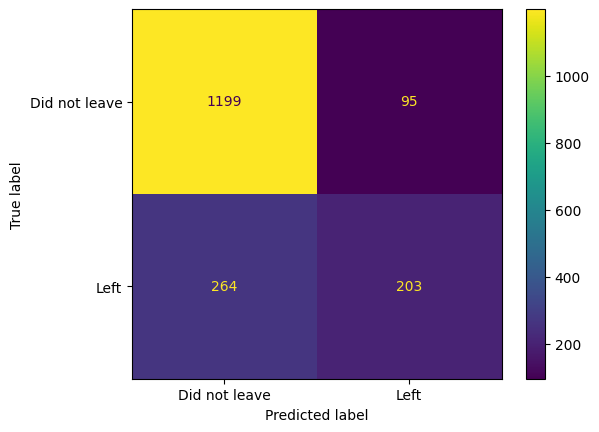

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # draws a confusion matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Did not leave", "Left"])
disp = disp.plot(values_format='d')


- **Problem:**
  - The **ratio of correctly classified people who left** (churned) is low.
  
- **Solution:**
  - The good news is that **XGBoost** has a parameter called `**scale_pos_weight**`, which helps handle **imbalanced data**. 
  - We can improve predictions by using **Cross Validation** to optimize the model's parameters.

- **Optimizing Parameters with Cross Validation and GridSearchCV:**
  - **XGBoost** has many **hyperparameters**—settings that we need to manually configure, as they are not automatically determined by XGBoost. These include:
    1. **`max_depth`**: The maximum depth of the tree.
    2. **`learning_rate`** (or "eta"): Controls the step size at each iteration.
    3. **`gamma`**: Encourages **pruning** by setting a minimum loss reduction needed to make a further split.
    4. **`reg_lambda`**: The **regularization parameter** that helps prevent overfitting.
  
  - Our goal is to find the **optimal values** for these hyperparameters to improve **accuracy** on the testing dataset.

- **Using GridSearchCV for Hyperparameter Tuning:**
  - Since we have multiple hyperparameters to optimize, we use **`GridSearchCV()`**.
    - With `GridSearchCV`, we specify a range of potential values for each hyperparameter.
    - It automatically tests **all possible combinations** of these values to find the best set of hyperparameters for the model.


In [19]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during
from sklearn.model_selection import GridSearchCV # cross validation

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
    seed=42,
    subsample=0.9,
    colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.ht
    verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
    n_jobs = 10,
    cv = 3,
)

optimal_params.fit(
    X_train,
    y_train,    
    #eval_metric='auc',
    verbose=False)
print(optimal_params.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 1}


In [20]:
clf_xgb_after_grid_search = xgb.XGBClassifier(
    objective='binary:logistic',
    early_stopping_rounds=10,    
    eval_metric='aucpr',  
    seed=42,
    #------------from optimal_params.best_params_
    gamma=0,
    learning_rate=0.05,
    max_depth=4,
    reg_lambda=1.0,
    scale_pos_weight=1)

clf_xgb_after_grid_search.fit(X_train,
            y_train,
            verbose=True,
            eval_set=[(X_test, y_test)],                
            )
y_pred = clf_xgb_after_grid_search.predict(X_test)  # Predict on the test set

[0]	validation_0-aucpr:0.62915
[1]	validation_0-aucpr:0.63040
[2]	validation_0-aucpr:0.63237
[3]	validation_0-aucpr:0.63186
[4]	validation_0-aucpr:0.63634
[5]	validation_0-aucpr:0.64146
[6]	validation_0-aucpr:0.64073
[7]	validation_0-aucpr:0.64221
[8]	validation_0-aucpr:0.64090
[9]	validation_0-aucpr:0.64229
[10]	validation_0-aucpr:0.64101
[11]	validation_0-aucpr:0.64369
[12]	validation_0-aucpr:0.64366
[13]	validation_0-aucpr:0.63804
[14]	validation_0-aucpr:0.63902
[15]	validation_0-aucpr:0.63941
[16]	validation_0-aucpr:0.63666
[17]	validation_0-aucpr:0.64227
[18]	validation_0-aucpr:0.64240
[19]	validation_0-aucpr:0.64378
[20]	validation_0-aucpr:0.64854
[21]	validation_0-aucpr:0.64480
[22]	validation_0-aucpr:0.64436
[23]	validation_0-aucpr:0.64470
[24]	validation_0-aucpr:0.64487
[25]	validation_0-aucpr:0.64447
[26]	validation_0-aucpr:0.64577
[27]	validation_0-aucpr:0.64559
[28]	validation_0-aucpr:0.64327
[29]	validation_0-aucpr:0.64358


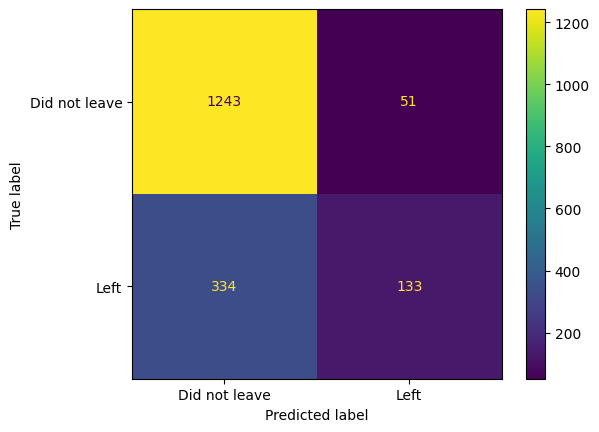

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Did not leave", "Left"])
disp = disp.plot(values_format='d')

# Not really better here, but it's how you gradually testing the best parameters...

weight:  {'SeniorCitizen': 18.0, 'tenure': 107.0, 'MonthlyCharges': 153.0, 'TotalCharges': 147.0, 'gender_Female': 15.0, 'Partner_No': 16.0, 'Dependents_No': 17.0, 'PhoneService_No': 4.0, 'MultipleLines_No': 13.0, 'MultipleLines_Yes': 1.0, 'InternetService_DSL': 2.0, 'InternetService_Fiber optic': 5.0, 'OnlineSecurity_No': 20.0, 'OnlineBackup_No': 25.0, 'OnlineBackup_Yes': 3.0, 'DeviceProtection_No': 4.0, 'DeviceProtection_Yes': 2.0, 'TechSupport_No': 22.0, 'TechSupport_Yes': 1.0, 'StreamingTV_No': 5.0, 'StreamingMovies_No': 15.0, 'StreamingMovies_Yes': 4.0, 'Contract_Month-to-month': 9.0, 'Contract_One year': 13.0, 'Contract_Two year': 5.0, 'PaperlessBilling_No': 16.0, 'PaymentMethod_Bank transfer (automatic)': 16.0, 'PaymentMethod_Credit card (automatic)': 8.0, 'PaymentMethod_Electronic check': 26.0, 'PaymentMethod_Mailed check': 9.0}
gain:  {'SeniorCitizen': 2.7144219875335693, 'tenure': 6.856982707977295, 'MonthlyCharges': 3.407114028930664, 'TotalCharges': 3.105593204498291, 'gend

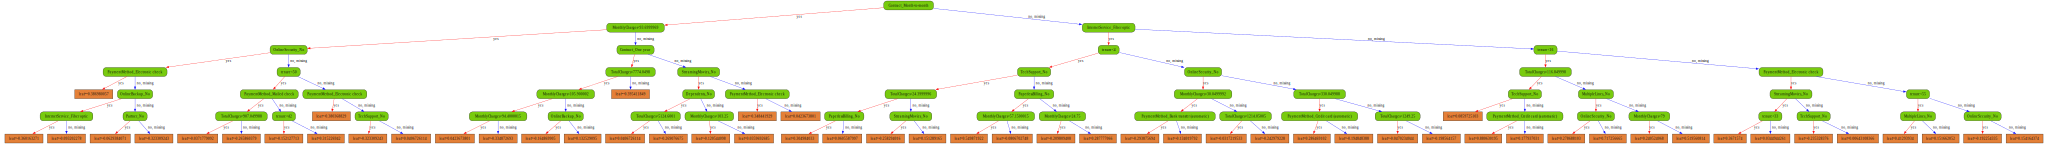

In [22]:
## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {
    'shape': 'box', ## make the nodes fancy
    'style': 'filled, rounded',
    'fillcolor': '#78cbe'}
leaf_params = {
    'shape': 'box',
    'style': 'filled',
    'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)